In [1]:
import mne
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from mne_bids import BIDSPath, read_raw_bids
from mne.decoding import SlidingEstimator, cross_val_multiscore
from bids import BIDSLayout
from mne.minimum_norm import (apply_inverse, apply_inverse_epochs,
                              read_inverse_operator)
from mne_connectivity import seed_target_indices, spectral_connectivity_epochs

In [2]:
BIDS_ROOT = '../data/bids'
FIGS_ROOT = '../figs'
DERIV_ROOT = '../data/bids/derivatives'
FS = 5000
RAW_TMIN = -0.2
RAW_TMAX = 0.5
TMIN = 0
TMAX = 0.25
FREQS = [50, 100, 150, 200, 250]

In [3]:
layout = BIDSLayout(BIDS_ROOT, derivatives = True)
fpaths = layout.get(scope = 'preprocessing',
                    res = 'hi',
                    suffix='epo',
                    extension = 'fif.gz',
                    return_type = 'filename')

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [10]:
epochs = mne.read_epochs(fpaths[10], preload = True)
events = epochs.events
n_epochs = len(events)

Reading /project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocessing/sub-9/sub-9_task-pitch_run-1_res-hi_desc-clean_epo.fif.gz ...
    Found the data of interest:
        t =    -200.00 ...     250.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Not setting metadata
1922 matching events found
No baseline correction applied
0 projection items activated


### Simulate channels with stim signals

In [5]:
# Load EEG data and events
bids_path = BIDSPath(root = BIDS_ROOT,
                     subject = '9',
                     task = 'pitch',
                     run = '1',
                     datatype = 'eeg')
raw = read_raw_bids(bids_path, verbose = False)
raw_events, raw_event_id = mne.events_from_annotations(raw)
raw_epochs = mne.Epochs(raw, 
                    events, 
                    baseline = None,
                    event_id = raw_event_id)

Used Annotations descriptions: ['100', '150', '200', '250', '50']
Not setting metadata
1922 matching events found
No baseline correction applied
0 projection items activated


/tmp/ipykernel_46277/2902170169.py:7: RuntimeWarning: There are channels without locations (n/a) that are not marked as bad: ['leog', 'reog', 'Aux1']
  raw = read_raw_bids(bids_path, verbose = False)
/tmp/ipykernel_46277/2902170169.py:7: RuntimeWarning: Not setting position of 1 stim channel found in montage:
['Aux1']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = read_raw_bids(bids_path, verbose = False)


In [6]:
# Create stim epochs by averaging over trials
stim_50 = raw_epochs['50'].get_data(['stim'])
stim_50 = stim_50.mean(0).flatten()
stim_100 = raw_epochs['100'].get_data(['stim'])
stim_100 = stim_100.mean(0).flatten()
stim_150 = raw_epochs['150'].get_data(['stim'])
stim_150 = stim_150.mean(0).flatten()
stim_200 = raw_epochs['200'].get_data(['stim'])
stim_200 = stim_200.mean(0).flatten()
stim_250 = raw_epochs['250'].get_data(['stim'])
stim_250 = stim_250.mean(0).flatten()

Loading data for 375 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 393 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 395 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 392 events and 3501 original time points ...
0 bad epochs dropped
Loading data for 367 events and 3501 original time points ...
0 bad epochs dropped


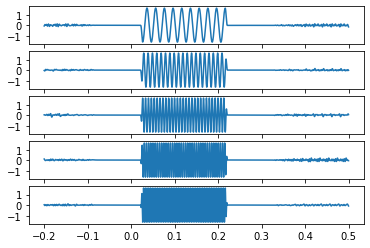

In [7]:
# Plot the stim signals
n_samples = len(stim_50)
t = np.linspace(RAW_TMIN, RAW_TMAX, n_samples, endpoint = False)

fig, axs = plt.subplots(5)
axs[0].plot(t, stim_50)
axs[1].plot(t, stim_100)
axs[2].plot(t, stim_150)
axs[3].plot(t, stim_200)
axs[4].plot(t, stim_250)

In [8]:
# Broadcast sine waves by number of epochs
sine_50_epochs = [stim_50]*n_epochs
sine_100_epochs = [stim_100]*n_epochs
sine_150_epochs = [stim_150]*n_epochs
sine_200_epochs = [stim_200]*n_epochs
sine_250_epochs = [stim_250]*n_epochs

# Combine sine waves into a data array
data = np.stack((sine_50_epochs, 
                 sine_100_epochs,
                 sine_150_epochs,
                 sine_200_epochs,
                 sine_250_epochs,
                ), axis = 1)
print(np.shape(data)) # n_epochs, n_channels, n_samples

# Specify channel info
info = mne.create_info(ch_names = ['50haz', 
                                   '100hz',
                                   '150hz',
                                   '200hz',
                                   '250hz'],
                       ch_types = ['stim'] * 5,
                       sfreq = FS)

# Manually add channel info to match original data to stop mne from shouting at us, very hacky
info['custom_ref_applied'] = True
info['description'] = 'Anonymized using a time shift to preserve age at acquisition'
info['experimenter'] = 'mne_anonymize'
info['highpass'] = 30.0
info['line_freq'] = 60.0
info['lowpass'] = 270.0
event_id = {'100': 10001, '150': 10002, '200': 10003, '250': 10004, '50': 10005}

# Manually add info that is passed in through mne.EpochsArray instead of in the info dict, also very hacky
baseline = (-0.20000000298023224, 0.0)

# Create Epochs object
simulated_epochs = mne.EpochsArray(data, 
                                   info, 
                                   events = events, 
                                   tmin = RAW_TMIN, 
                                   event_id = event_id, 
                                   baseline = baseline)


(1922, 5, 3501)
Not setting metadata
1922 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting custom_ref_applied cannot be set directly. Please use method inst.set_eeg_reference() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting highpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")
/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/mne/io/meas_info.py:864: UserWarning: Avoid manually setting lowpass cannot be set directly. Please use method inst.filter() instead.
  warnings.warn(f"Avoid manually setting {self._attributes[key]}")


0 bad epochs dropped


In [11]:
# Crop data
simulated_epochs = simulated_epochs.crop(tmin = TMIN,
                                         tmax = TMAX)
epochs = epochs.crop(tmin = TMIN)

In [12]:
# Combine original channels with simulated channels
combined_epochs = mne.epochs.add_channels_epochs([epochs, simulated_epochs])

### Compute coherence

In [13]:
data = combined_epochs.get_data()
fmin = (45, 95, 145, 195, 245)
fmax = (55, 105, 155, 205, 255)

In [14]:
# Set indices of channel pairs to compute coherence across
stim_indices = np.array([62, 63, 64, 65, 66]*62)
chan_indices = np.repeat(np.arange(1, 63, 1), 5)
indices = (stim_indices, chan_indices)

In [15]:
coh = spectral_connectivity_epochs(
    data, method='coh', mode='fourier', indices=indices,
    sfreq=FS, fmin=fmin, fmax=fmax, faverage=True, n_jobs=1)
freqs = coh.freqs

print('Frequencies in Hz over which coherence was averaged for 50 Hz: ')
print(freqs[0])
print('Frequencies in Hz over which coherence was averaged for 100 Hz: ')
print(freqs[1])
print('Frequencies in Hz over which coherence was averaged for 150 Hz: ')
print(freqs[2])
print('Frequencies in Hz over which coherence was averaged for 200 Hz: ')
print(freqs[3])
print('Frequencies in Hz over which coherence was averaged for 250 Hz: ')
print(freqs[4])

Connectivity computation...
    computing connectivity for 310 connections
    using t=0.000s..0.250s for estimation (1251 points)
    computing connectivity for the bands:
     band 1: 48.0Hz..52.0Hz (2 points)
     band 2: 95.9Hz..103.9Hz (3 points)
     band 3: 147.9Hz..151.9Hz (2 points)
     band 4: 195.8Hz..203.8Hz (3 points)
     band 5: 247.8Hz..251.8Hz (2 points)
    connectivity scores will be averaged for each band
    using FFT with a Hanning window to estimate spectra
    the following metrics will be computed: Coherence
    computing connectivity for epoch 1
    computing connectivity for epoch 2
    computing connectivity for epoch 3
    computing connectivity for epoch 4
    computing connectivity for epoch 5
    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity fo

    computing connectivity for epoch 191
    computing connectivity for epoch 192
    computing connectivity for epoch 193
    computing connectivity for epoch 194
    computing connectivity for epoch 195
    computing connectivity for epoch 196
    computing connectivity for epoch 197
    computing connectivity for epoch 198
    computing connectivity for epoch 199
    computing connectivity for epoch 200
    computing connectivity for epoch 201
    computing connectivity for epoch 202
    computing connectivity for epoch 203
    computing connectivity for epoch 204
    computing connectivity for epoch 205
    computing connectivity for epoch 206
    computing connectivity for epoch 207
    computing connectivity for epoch 208
    computing connectivity for epoch 209
    computing connectivity for epoch 210
    computing connectivity for epoch 211
    computing connectivity for epoch 212
    computing connectivity for epoch 213
    computing connectivity for epoch 214
    computing co

    computing connectivity for epoch 391
    computing connectivity for epoch 392
    computing connectivity for epoch 393
    computing connectivity for epoch 394
    computing connectivity for epoch 395
    computing connectivity for epoch 396
    computing connectivity for epoch 397
    computing connectivity for epoch 398
    computing connectivity for epoch 399
    computing connectivity for epoch 400
    computing connectivity for epoch 401
    computing connectivity for epoch 402
    computing connectivity for epoch 403
    computing connectivity for epoch 404
    computing connectivity for epoch 405
    computing connectivity for epoch 406
    computing connectivity for epoch 407
    computing connectivity for epoch 408
    computing connectivity for epoch 409
    computing connectivity for epoch 410
    computing connectivity for epoch 411
    computing connectivity for epoch 412
    computing connectivity for epoch 413
    computing connectivity for epoch 414
    computing co

    computing connectivity for epoch 591
    computing connectivity for epoch 592
    computing connectivity for epoch 593
    computing connectivity for epoch 594
    computing connectivity for epoch 595
    computing connectivity for epoch 596
    computing connectivity for epoch 597
    computing connectivity for epoch 598
    computing connectivity for epoch 599
    computing connectivity for epoch 600
    computing connectivity for epoch 601
    computing connectivity for epoch 602
    computing connectivity for epoch 603
    computing connectivity for epoch 604
    computing connectivity for epoch 605
    computing connectivity for epoch 606
    computing connectivity for epoch 607
    computing connectivity for epoch 608
    computing connectivity for epoch 609
    computing connectivity for epoch 610
    computing connectivity for epoch 611
    computing connectivity for epoch 612
    computing connectivity for epoch 613
    computing connectivity for epoch 614
    computing co

    computing connectivity for epoch 791
    computing connectivity for epoch 792
    computing connectivity for epoch 793
    computing connectivity for epoch 794
    computing connectivity for epoch 795
    computing connectivity for epoch 796
    computing connectivity for epoch 797
    computing connectivity for epoch 798
    computing connectivity for epoch 799
    computing connectivity for epoch 800
    computing connectivity for epoch 801
    computing connectivity for epoch 802
    computing connectivity for epoch 803
    computing connectivity for epoch 804
    computing connectivity for epoch 805
    computing connectivity for epoch 806
    computing connectivity for epoch 807
    computing connectivity for epoch 808
    computing connectivity for epoch 809
    computing connectivity for epoch 810
    computing connectivity for epoch 811
    computing connectivity for epoch 812
    computing connectivity for epoch 813
    computing connectivity for epoch 814
    computing co

    computing connectivity for epoch 991
    computing connectivity for epoch 992
    computing connectivity for epoch 993
    computing connectivity for epoch 994
    computing connectivity for epoch 995
    computing connectivity for epoch 996
    computing connectivity for epoch 997
    computing connectivity for epoch 998
    computing connectivity for epoch 999
    computing connectivity for epoch 1000
    computing connectivity for epoch 1001
    computing connectivity for epoch 1002
    computing connectivity for epoch 1003
    computing connectivity for epoch 1004
    computing connectivity for epoch 1005
    computing connectivity for epoch 1006
    computing connectivity for epoch 1007
    computing connectivity for epoch 1008
    computing connectivity for epoch 1009
    computing connectivity for epoch 1010
    computing connectivity for epoch 1011
    computing connectivity for epoch 1012
    computing connectivity for epoch 1013
    computing connectivity for epoch 1014
 

    computing connectivity for epoch 1187
    computing connectivity for epoch 1188
    computing connectivity for epoch 1189
    computing connectivity for epoch 1190
    computing connectivity for epoch 1191
    computing connectivity for epoch 1192
    computing connectivity for epoch 1193
    computing connectivity for epoch 1194
    computing connectivity for epoch 1195
    computing connectivity for epoch 1196
    computing connectivity for epoch 1197
    computing connectivity for epoch 1198
    computing connectivity for epoch 1199
    computing connectivity for epoch 1200
    computing connectivity for epoch 1201
    computing connectivity for epoch 1202
    computing connectivity for epoch 1203
    computing connectivity for epoch 1204
    computing connectivity for epoch 1205
    computing connectivity for epoch 1206
    computing connectivity for epoch 1207
    computing connectivity for epoch 1208
    computing connectivity for epoch 1209
    computing connectivity for epo

    computing connectivity for epoch 1383
    computing connectivity for epoch 1384
    computing connectivity for epoch 1385
    computing connectivity for epoch 1386
    computing connectivity for epoch 1387
    computing connectivity for epoch 1388
    computing connectivity for epoch 1389
    computing connectivity for epoch 1390
    computing connectivity for epoch 1391
    computing connectivity for epoch 1392
    computing connectivity for epoch 1393
    computing connectivity for epoch 1394
    computing connectivity for epoch 1395
    computing connectivity for epoch 1396
    computing connectivity for epoch 1397
    computing connectivity for epoch 1398
    computing connectivity for epoch 1399
    computing connectivity for epoch 1400
    computing connectivity for epoch 1401
    computing connectivity for epoch 1402
    computing connectivity for epoch 1403
    computing connectivity for epoch 1404
    computing connectivity for epoch 1405
    computing connectivity for epo

    computing connectivity for epoch 1579
    computing connectivity for epoch 1580
    computing connectivity for epoch 1581
    computing connectivity for epoch 1582
    computing connectivity for epoch 1583
    computing connectivity for epoch 1584
    computing connectivity for epoch 1585
    computing connectivity for epoch 1586
    computing connectivity for epoch 1587
    computing connectivity for epoch 1588
    computing connectivity for epoch 1589
    computing connectivity for epoch 1590
    computing connectivity for epoch 1591
    computing connectivity for epoch 1592
    computing connectivity for epoch 1593
    computing connectivity for epoch 1594
    computing connectivity for epoch 1595
    computing connectivity for epoch 1596
    computing connectivity for epoch 1597
    computing connectivity for epoch 1598
    computing connectivity for epoch 1599
    computing connectivity for epoch 1600
    computing connectivity for epoch 1601
    computing connectivity for epo

    computing connectivity for epoch 1775
    computing connectivity for epoch 1776
    computing connectivity for epoch 1777
    computing connectivity for epoch 1778
    computing connectivity for epoch 1779
    computing connectivity for epoch 1780
    computing connectivity for epoch 1781
    computing connectivity for epoch 1782
    computing connectivity for epoch 1783
    computing connectivity for epoch 1784
    computing connectivity for epoch 1785
    computing connectivity for epoch 1786
    computing connectivity for epoch 1787
    computing connectivity for epoch 1788
    computing connectivity for epoch 1789
    computing connectivity for epoch 1790
    computing connectivity for epoch 1791
    computing connectivity for epoch 1792
    computing connectivity for epoch 1793
    computing connectivity for epoch 1794
    computing connectivity for epoch 1795
    computing connectivity for epoch 1796
    computing connectivity for epoch 1797
    computing connectivity for epo

In [16]:
np.shape(coh) # n_chans * n_stim, n_freqs
print(np.shape(coh.get_data()))
coh.get_data()[120:125,:]

# COMPUTE COHERENCE SEPARATELY FOR EACH CONDITIONSNSN!!!

(310, 5)


array([[0.01355686, 0.01404192, 0.01105333, 0.01210165, 0.00355317],
       [0.01355686, 0.01404192, 0.01105333, 0.01210165, 0.00355317],
       [0.01355686, 0.01404192, 0.01105333, 0.01210165, 0.00355317],
       [0.01355686, 0.01404192, 0.01105333, 0.01210165, 0.00355317],
       [0.01355686, 0.01404192, 0.01105333, 0.01210165, 0.00355317]])

In [ ]:
# Create data frame (chan, stim_chan, coh_at_50hz, coh_at_100hz, coh_at_150, coh_at_200, coh_at_250)

In [ ]:
epochs.events

In [ ]:
mne.pick_types(combined_epochs.info, stim = True, eeg = True)

In [ ]:
mne.pick_types(simulated_epochs.info, stim = True)